In [1]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [2]:
train_data = pd.read_csv("../data/preprocessed_train_data.csv")
test_data = pd.read_csv("../data/preprocessed_test_data.csv")

In [3]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5398 entries, 0 to 5397
Data columns (total 23 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   account_open_date                        5398 non-null   object 
 1   age                                      5398 non-null   int64  
 2   location                                 5398 non-null   object 
 3   occupation                               5398 non-null   object 
 4   income_level                             5398 non-null   int64  
 5   fico_score                               5398 non-null   float64
 6   delinquency_status                       5398 non-null   int64  
 7   charge_off_status                        5398 non-null   int64  
 8   number_of_credit_applications            5398 non-null   int64  
 9   debt_to_income_ratio                     5398 non-null   float64
 10  payment_methods_high_risk                5398 no

## Tranforming Date columns to Days

In [4]:
# Object -> Date
train_data['account_open_date'] = pd.to_datetime(train_data['account_open_date'])
train_data['earliest_credit_account'] = pd.to_datetime(train_data['earliest_credit_account'])
train_data['recent_trade_activity'] = pd.to_datetime(train_data['recent_trade_activity'])

test_data['account_open_date'] = pd.to_datetime(test_data['account_open_date'])
test_data['earliest_credit_account'] = pd.to_datetime(test_data['earliest_credit_account'])
test_data['recent_trade_activity'] = pd.to_datetime(test_data['recent_trade_activity'])

In [5]:
#Date -> Days

train_data["account_age_days"] = (pd.Timestamp("today") - train_data["account_open_date"]).dt.days
train_data["earliest_credit_account_age_days"] = (pd.Timestamp("today") - train_data["earliest_credit_account"]).dt.days
train_data["days_recent_trade_activity"] = (pd.Timestamp("today") - train_data["recent_trade_activity"]).dt.days

test_data["account_age_days"] = (pd.Timestamp("today") - test_data["account_open_date"]).dt.days
test_data["earliest_credit_account_age_days"] = (pd.Timestamp("today") - test_data["earliest_credit_account"]).dt.days
test_data["days_recent_trade_activity"] = (pd.Timestamp("today") - test_data["recent_trade_activity"]).dt.days

In [6]:
# Dropping original date colcolumns 

columns_to_drop = ['account_open_date', 'earliest_credit_account', 'recent_trade_activity']

train_data = train_data.drop(columns=columns_to_drop)
test_data = test_data.drop(columns=columns_to_drop)

In [7]:
train_data_copy = train_data.copy()
test_data_copy = test_data.copy()

In [8]:
target = 'charge_off_status'

X_train = train_data_copy.drop(columns=[target])  
y_train = train_data_copy[target]  

In [9]:
categorical_features = ["occupation", "location"]

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train[categorical_features])

encoded_columns = encoder.get_feature_names_out(categorical_features)
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoded_columns)

X_train = X_train.drop(columns=categorical_features).reset_index(drop=True)

X_train = pd.concat([X_train, X_train_encoded], axis=1)

## Mutual Information

In [10]:
mi = mutual_info_classif(X_train, y_train)
mi_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Mutual Information': mi
})
mi_df_sorted = mi_df.sort_values(by='Mutual Information', ascending=False)
print(mi_df_sorted)

                                    Feature  Mutual Information
3                        delinquency_status            0.189941
4             number_of_credit_applications            0.159818
9             number_of_delinquent_accounts            0.152485
10             number_of_defaulted_accounts            0.119434
8                 avg_balance_last_12months            0.103676
2                                fico_score            0.096409
13               unusual_submission_pattern            0.086038
6                 payment_methods_high_risk            0.071149
11        new_accounts_opened_last_12months            0.070332
5                      debt_to_income_ratio            0.055989
7                               max_balance            0.054254
12  multiple_applications_short_time_period            0.044583
14  applications_submitted_during_odd_hours            0.033274
23                    occupation_Consultant            0.017242
28                 occupation_Retail Wor

## Fico Score -> Fico Score category 

In [11]:
bins = [0, 580, 669, 739, 799, 850]  
labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Exceptional']

# bins = [0,  669, 739, 850]  
# labels = ['Poor', 'Good', 'Very Good']

train_data_copy['fico_category'] = pd.cut(train_data_copy['fico_score'], bins=bins, labels=labels, right=False)

C:\Users\hcham\AppData\Local\Temp\ipykernel_28588\1313621077.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot_table = train_data_copy.groupby(["fico_category", "charge_off_status"]).size().unstack()


<Figure size 600x400 with 0 Axes>

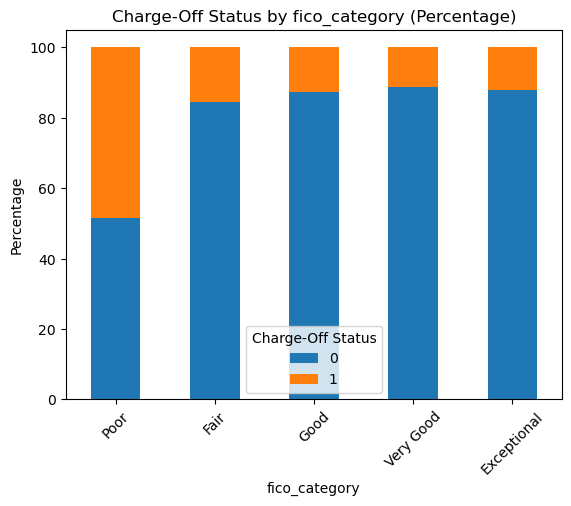

In [12]:
plt.figure(figsize=(6, 4))
pivot_table = train_data_copy.groupby(["fico_category", "charge_off_status"]).size().unstack()
pivot_table_percentage = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100
pivot_table_percentage.plot(kind="bar", stacked=True )
plt.title("Charge-Off Status by fico_category (Percentage)")
plt.xlabel("fico_category")
plt.ylabel("Percentage")
plt.legend(title="Charge-Off Status")
plt.tick_params(axis='x', rotation=45)
plt.show()

In [13]:
# bins = [0, 580, 669, 739, 799, 850]  
# labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Exceptional']

# train_data['fico_category'] = pd.cut(train_data['fico_score'], bins=bins, labels=labels, right=False)
# test_data['fico_category'] = pd.cut(test_data['fico_score'], bins=bins, labels=labels, right=False)

## Age -> Age Categories 

In [18]:
bins = [0, 580, 669, 739, 799, 850]  
labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Exceptional']

# bins = [0,  669, 739, 850]  
# labels = ['Poor', 'Good', 'Very Good']

train_data_copy['age_category'] = pd.cut(train_data_copy['age'], bins=bins, labels=labels, right=False)

In [ ]:
plt.figure(figsize=(6, 4))
pivot_table = train_data_copy.groupby(["fico_category", "charge_off_status"]).size().unstack()
pivot_table_percentage = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100
pivot_table_percentage.plot(kind="bar", stacked=True )
plt.title("Charge-Off Status by fico_category (Percentage)")
plt.xlabel("fico_category")
plt.ylabel("Percentage")
plt.legend(title="Charge-Off Status")
plt.tick_params(axis='x', rotation=45)
plt.show()

## Delinquency_status -> Delinquency_status Groups

In [15]:
bins = [0, 72.5, float('inf')]  
labels = ['Normal', 'High']

train_data_copy['delinquency_group'] = pd.cut(train_data_copy['delinquency_status'], bins=bins, labels=labels, right=False)

In [16]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5398 entries, 0 to 5397
Data columns (total 23 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   age                                      5398 non-null   int64  
 1   location                                 5398 non-null   object 
 2   occupation                               5398 non-null   object 
 3   income_level                             5398 non-null   int64  
 4   fico_score                               5398 non-null   float64
 5   delinquency_status                       5398 non-null   int64  
 6   charge_off_status                        5398 non-null   int64  
 7   number_of_credit_applications            5398 non-null   int64  
 8   debt_to_income_ratio                     5398 non-null   float64
 9   payment_methods_high_risk                5398 non-null   int64  
 10  max_balance                              5398 no

In [17]:
train_data.to_csv("../data/model_train_data.csv", index=False)
test_data.to_csv("../data/model_test_data.csv", index=False)